# Decision tree, K-nearest neighbor, and the Bias-Variance Trade-Off

**Acknowledgment**: Noah Smith, Chris Ketelsen

In [3]:
import math
import pickle
import gzip
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

### [30 points] Problem 1 - Decision tree
***

Consider the problem of predicting whether a person has a college degree based on age, salary, and Colorado residency. 
The dataset looks like the following.

| Age   | Salary         | Colorado Residency      | College degree| 
|:------:|:------------:| :-----------:|---:|
| 24 | 40,000 | Yes | Yes |
| 53 | 52,000 | No | No |
| 23 | 25,000 | Yes | No |
| 25 | 77,000 | Yes | Yes |
| 32 | 48,000 | No | Yes |
| 52 | 110,000 | Yes | Yes |
| 22 | 38,000 | Yes | Yes |
| 43 | 44,000 | Yes | No |
| 52 | 27,000 | No | No |
| 48 | 65,000 | Yes | Yes |


**Part 1 [5 points]**: Convert the above table to data. Two variables should be created:
        
1. $x$ is a $10*3$ matrix that contains the data from columns 0, 1, and 2. Colorado residency is represented by 1 (yes) and 0 (no).
2. $y$ contains the labels (college degree), 1 (yes) and 0 (no).

In [4]:
x = np.array([[24, 40000, 1],
    [53, 52000, 0],
    [23, 25000, 1],
    [25, 77000, 1],
    [32, 48000, 0],
    [52, 110000, 1],
    [22, 38000, 1],
    [43, 44000, 1],
    [52, 27000, 0],
    [48, 65000, 1]])

y = [1,0,0,1,1,1,1,0,0,1]

**Part 2 [16 points]:** Criteria for choosing a feature to split.

**[2 points]** We start with no splitting. Assuming that our algorithm is deterministic, what is the smallest number of mistakes we can make if we do not use any of the features and what is the algorithm? (**Write your answer in the Markdown cell below.**)

**The algorithm without splitting on any features is to predict the label that occurs most often in the dataset. In this case, we would always predict "Yes", and in our dataset, the smallest number of mistakes we could make is 4.**

**[5 points]** We start by considering the variable *Colorado residency*. The first criteria is based on the numbeer of mistakes. We need to build a confusion matrix between Colorado residency and college degree.

How many mistakes will we make if we split based on Colorado residency? (**Answer below by finishing the code.**)

In [7]:
def get_error_in_leaf(y, ids):
    """
    Returns the errors in a leaf node of a decision tree.
    This function can be used to answer the previous question automatically.
    
    :@param y: all labels
    :@param ids: the subset of indexes in the leaf node
    """
    count_zero, count_one = 0,0
    for i in ids:
        if y[i] == 0:
            count_zero += 1
        else:
            count_one += 1
            
    return min(count_one, count_zero)

def error_criteria(y, root, left_child, right_child):
    """
    Returns the number of errors if we split the root into the left child and the right child.
    
    :@param y: all labels
    :@param root: indexes of all the data points in the root
    :@param left_child: the subset of indexes in the left child
    :@param right_child: the subset of indexes in the right child
    """
    return get_error_in_leaf(y, left_child) + get_error_in_leaf(y, right_child)

def value_split_binary_feature(x, y, fid, root, criteria_func):
    left_child = [i for i in root if x[i, fid] == 0]
    right_child = [i for i in root if x[i, fid] == 1]
    return criteria_func(y, root, left_child, right_child)

# Colorado residency should correpsond to the third column in your data x
fid = 2
root = list(range(len(y))) # root includes all data points
mistakes = value_split_binary_feature(x, y, fid, root, error_criteria)
print("Number of mistakes: %d" % mistakes)

Number of mistakes: 3


**[3 points]** Alternatively, we can use information gain to split the data. To get you familiar with MathJax, please write the equation necessary to compute information gain if we split data $D$ into $D_1$ and $D_2$. **Write your answer in the Markdown cell below.**

\begin{equation*}
IG\left(D \rightarrow D_1,D_2\right) = H\left(D\right) - \frac{\left| D_1 \right|}{\left| D \right|}H\left( D_1 \right) - \frac{\left| D_2 \right|}{\left| D \right|}H\left( D_2 \right) , \\[0.5cm] \text{where  } H\left(x\right) = -p\log_2\left(p\right) - \left(1 - p\right)\log_2\left(1 - p\right) , \\[0.5cm] \text{where } p \text{ is the positive fraction of the class } x
\end{equation*}

**[6 points]** Now we write a function for computing information gain. Use log2 for entropy computation.

In [8]:
def entropy(y, ids):
    """
    Returns the entropy in the labels for the data points in ids.
    
    :@param y: all labels
    :@param ids: the indexes of data points
    """
    if len(ids) == 0: # deal with corner case when there is no data point.
        return 0
    
    pos_count = 0
    for i in ids:
        if y[i] == 1:
            pos_count += 1
            
    p = pos_count/len(ids)
    if p == 0 or p == 1:
        return 0
    else:
        return -(p * math.log(p,2)) - ((1.0-p) * math.log(1.0-p,2))
            
def information_gain_criteria(y, root, left_child, right_child):
    """
    Returns the information gain by splitting root into left child and right child.
    
    :@param y: all labels
    :@param root: indexes of all the data points in the root
    :@param left_child: the subset of indexes in the left child
    :@param right_child: the subset of indexes in the right child
    """
    return entropy(y, root) - ((abs(len(left_child))/abs(len(root))) * entropy(y, left_child)) - ((abs(len(right_child))/abs(len(root))) * entropy(y, right_child))
    
fid = 2
root = list(range(len(y))) # root includes all data points
info_gain = value_split_binary_feature(x, y, fid, root, information_gain_criteria)

#NOTE: I added this print statement here, it may need to be removed for autograding
print("Information gain:", info_gain)

Information gain: 0.0912774462416801


**Part 3 [9 points]**: Deal with continuous features.
    
**[6 points]** One way to deal with continuous (or ordinal) data is to define binary features based on thresholding of continuous features like Age and Salary.
For example, you might convert ages to 0 if age is less than or equal to 50 and 1 otherwise.

In [9]:
def value_split_continuous_feature(x, y, fid, root, criteria_func=information_gain_criteria):
    """
    Return the best value and its corresponding threshold by splitting based on a continuous feature.

    :@param x: all feature values
    :@param y: all labels
    :@param fid: feature id to split the tree based on
    :@param root: indexes of all the data points in the root
    :@param criteria_func: the splitting criteria function
    """
    best_value, best_thres = 0, 0
    # Loop over the values defined by root, compute the information gain of splitting with that as threshold
    # and take the max information gain
    for i in root:
        left_child = [j for j in root if x[j, fid] < x[i, fid]]
        right_child = [j for j in root if x[j, fid] >= x[i, fid]]
                
        ig = criteria_func(y, root, left_child, right_child)
        if ig > best_value:
            best_value = ig
            best_thres = x[i, fid]
            
    return best_value, best_thres

root = list(range(len(y))) # root includes all data points
fid = 0
age_value, age_thres = value_split_continuous_feature(x, y, fid, root, information_gain_criteria)
fid = 1
salary_value, salary_thres = value_split_continuous_feature(x, y, fid, root, information_gain_criteria)
print("Age: max information gain of", age_value, "with threshold of just below", age_thres)
print("Salary: max information gain of", salary_value, "with threshold of just below", salary_thres)

Age: max information gain of 0.1444843438056279 with threshold of just below 53
Salary: max information gain of 0.3219280948873623 with threshold of just below 38000


**[3 points]** Based on the current information gain by splitting different features, if we build a decision stump (decision tree with depth 1) greedily, which feature should we choose? **Write down your answer in the Markdown cell below.**

**To build a decision stump greedily, we would split on the _salary_ feature as that warranted greater information gain than the age feature**

### [35 points] Problem 2- KNN for Handwritten Digit Recognition 
***

In this problem you'll implement a K-Nearest Neighbor framework to take an image of a handwritten digit and predict which digit it corresponds to.  

![Samples of Handwritten Digits](figs/mnist.png "MNIST Digits")

To keep run times down we'll only consider the subset of the MNIST data set consisting of the digits $3, 7, 8$ and $9$. 

**Part A [6 points]**: Executing the following cells will load training and validation data and plot an example handwritten digit.  Explore the training and validation sets and answer the following questions: 

- How many pixels are in each image in the data set?  
- How many examples are there from each class in the training set? 
- How many examples are there from each class in the validation set? 

In [14]:
X_train, y_train, X_valid, y_valid = pickle.load(gzip.open("data/mnist21x21_3789.pklz", "rb"))

In [15]:
def view_digit(x, label=None):
    fig = plt.figure(figsize=(3,3))
    plt.imshow(x.reshape(21,21), cmap='gray');
    plt.xticks([]); plt.yticks([]);
    if label: plt.xlabel("true: {}".format(label), fontsize=16)

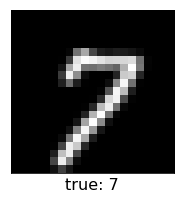

In [16]:
training_index = 0
view_digit(X_train[training_index], y_train[training_index])

In [17]:
# Write code for answering the questions in Part A and then put your answer in the Markdown cell below.
print("Number of pixels in X_train: %s" % X_train.shape[1])
print("Number of examples from X_train: %s" % X_train.shape[0])
print("Number of examples from X_valid: %s" % X_valid.shape[0])

Number of pixels in X_train: 441
Number of examples from X_train: 4000
Number of examples from X_valid: 1000


**There are _441 pixels_ in each image, making them 21 x 21.**

**There are _4000 examples_ in the training data.**

**There are _1000 examples_ in the validation data.**

In [18]:
class KNN:
    """
    Class to store data for regression problems 
    """
    def __init__(self, X_train, y_train, K=5, distance_weighted=False):
        """
        Creates a kNN instance

        :param X_train: Training data input in 2D ndarray 
        :param y_train: Training data output in 1D ndarray 
        :param K: The number of nearest points to consider in classification
        :param distance_weighted: Bool indicating whether to use distance weighting
        """
        
        # Import and build the BallTree on training features 
        from sklearn.neighbors import BallTree
        self.balltree = BallTree(X_train)
        
        # Cache training labels and parameter K 
        self.y_train = y_train
        self.K = K 
        
        # Boolean flag indicating whether to do distance weighting 
        self.distance_weighted = distance_weighted
        
    def majority(self, neighbor_indices, neighbor_distances=None):
        """
        Given indices of nearest neighbors in training set, return the majority label. 
        Break ties by considering 1 fewer neighbor until a clear winner is found. 

        :param neighbor_indices: The indices of the K nearest neighbors in self.X_train 
        :param neighbor_distances: Corresponding distances from query point to K nearest neighbors. 
        """
        count = {}
            
        for i, val in enumerate(self.y_train[neighbor_indices]):
            if val not in count.keys():
                count[val] = 0
            if self.distance_weighted:
                if neighbor_distances[i] == 0:
                    return val
                else:
                    count[val] += (1/neighbor_distances[i])
            else:
                count[val] += 1

        max_key = max(count, key=count.get)
        conflicts  = [k for k,v in count.items() if v == count[max_key]]

        if len(conflicts) > 1:
            # Note: this only works if neightbor_indices is ordered
            if (self.distance_weighted):
                return self.majority(neighbor_indices[:-1], neighbor_distances[:-1])
            else:
                return self.majority(neighbor_indices[:-1], None)
        else:
            return max_key
    
    def classify(self, x):
        """
        Given a query point, return the predicted label 
        
        :param x: a query point stored as an ndarray  
        """
        # Find k nearest neighbor indicies
        nearest_dists, nearest_inds = self.balltree.query([x], self.K)
        return self.majority(nearest_inds[0], nearest_dists[0])
        
    def predict(self, X):
        """
        Given an ndarray of query points, return yhat, an ndarray of predictions 

        :param X: an (m x p) dimension ndarray of points to predict labels for 
        """
        yhat = [None] * X.shape[0]
        for i, v in enumerate(X):
            yhat[i] = self.classify(v)
            
        return yhat

**Part B [10 points]**: Modify the class above to implement an Unweighted KNN classifier.  There are three methods that you need to complete: 

- `predict`: Given an $m \times p$ matrix of validation data with $m$ examples each with $p$ features, return a length-$m$ vector of predicted labels by calling the `classify` function on each example. 
- `classify`: Given a single query example with $p$ features, return its predicted class label as an integer using KNN by calling the `majority` function. 
- `majority`: Given an array of indices into the training set corresponding to the $K$ training examples that are nearest to the query point, return the majority label as an integer.  If there is a tie for the majority label using $K$ nearest neighbors, reduce $K$ by 1 and try again.  Continue reducing $K$ until there is a winning label. 

**Notes**: 
- Don't even think about implementing nearest-neighbor search or any distance metrics yourself.  Instead, go read the documentation for Scikit-Learn's [BallTree](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html) object.  You will find that its implemented [query](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html#sklearn.neighbors.BallTree.query) method can do most of the heavy lifting for you. 
- Do not use Scikit-Learn's KNeighborsClassifier in this problem.  We're implementing this ourselves. 
- You don't need to worry about the `distance_weighted` flag until **Part C**, but we recommend reading ahead a bit. It might be good to think about your implementation of **Part C** before implementing **Part B**. 
- When you think you're done, execute the following cell to run 4 unit tests based on the example starting on Slide 24 of the [KNN Lecture](https://chenhaot.com/courses/csci4622/slides/lesson05.pdf).

In [19]:
%run -i tests/tests.py "prob 2A"

test1NNclassify (__main__.TestUnweightedKNN) ... ok
test2NNclassify (__main__.TestUnweightedKNN) ... ok
test3NNclassify (__main__.TestUnweightedKNN) ... ok
test3NNpredict (__main__.TestUnweightedKNN) ... ok

----------------------------------------------------------------------
Ran 4 tests in 2.367s

OK


<Figure size 432x288 with 0 Axes>

**Part C [5 points]**: Modify the `KNN` class to perform the distance-weighted KNN classification.
The so-called Distance-Weighted KNN classifier assigns weights to the the nearest-neighbor training examples proportional to the inverse-distance from the training example to the query point.  Classification is performed by summing the weights associated with each class and predicting the class with the highest weighted-majority vote.  Mathematically we might describe the weighted-vote for a class $c$ as 

$$
\textrm{Weighted-Vote}(c) = \displaystyle\sum_{i \in {\cal N}_K} I(y_i = c) \times \dfrac{1}{\|{\bf x}_i - {\bf x}\|}
$$

A word of caution: it's certainly possible that a query point could be distance $0$ away from some training example.  If this happens your implementation should handle it gracefully and return the appropriate class label.   

When you think you're done, execute the following cell to run three final unit tests corresponding to the example on Slide 43 of the [KNN Lecture](https://chenhaot.com/courses/csci4622/slides/lesson05.pdf). Make sure that the changes you make in **Part C** do not affect the unit tests from **Part B**. 

In [20]:
%run -i tests/tests.py "prob 2B"

test5NNclassify (__main__.TestWeightedKNN) ... ok
test3NNclassify (__main__.TestWeightedKNN) ... ok
test5NNpredict (__main__.TestWeightedKNN) ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.004s

OK


**Part D [7 points]**: Use your `KNN` class to perform Unweighted KNN on the validation data with $K=3$ and do the following: 

- **[2 points]** Create a **confusion matrix** (feel free to use the Scikit-Learn [confusion_matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) function).  

In [21]:
knn = KNN(X_train, y_train, K=3, distance_weighted=True)
yhat_valid = knn.predict(X_valid)
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_valid, yhat_valid))

[[236   2  10   2]
 [  1 244   1   4]
 [  9   0 233   8]
 [  3   3   0 244]]


- **[2 points]** Based on your confusion matrix, which digits seem to get confused with other digits the most? 

**The digits that are the most often confused for eachother are 3 and 8, with a total of 19 mislabels.**


- **[3 points]** Find one misclassified validation example and plot it with the `view_digit` function along with plots of its three nearest neighbors in the training set. 


Missed digit: Mislabeled as 9


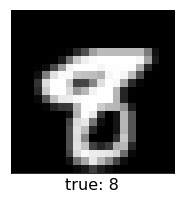

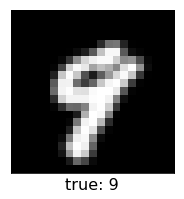

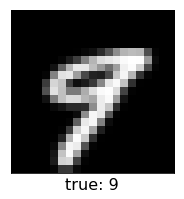

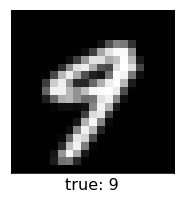

In [23]:
err = -1
for i,v in enumerate(yhat_valid):
    if v != y_valid[i]:
        err = i
        break
print("Missed digit: Mislabeled as %s" % v)        
view_digit(X_valid[err], y_valid[err])

_, nearest_inds = knn.balltree.query([X_valid[err]], 3)
for i in nearest_inds[0]:
    view_digit(X_train[i], y_train[i])

**Part E [7 points]**: **[4 points]** Create a plot of the accuracy of both Unweighted and Distance-Weighted KNN on the validation set on the same set of axes for $K=1, 2, \ldots, 20$ (feel free to go out to $K=30$ if your implementation is efficient enough to allow it).

In [24]:
acc = []
wacc = []
allks = range(1,30)

for i in allks:
    uw_knn = KNN(X_train, y_train, i, False)
    w_knn = KNN(X_train, y_train, i, True)
    uw_yhat = uw_knn.predict(X_valid)
    w_yhat = w_knn.predict(X_valid)
    
    uw_correct = 0
    w_correct = 0
    for j in range(len(y_valid)):
        if uw_yhat[j] == y_valid[j]:
            uw_correct += 1
        if w_yhat[j] == y_valid[j]:
            w_correct += 1
            
    acc.append(uw_correct/10)
    wacc.append(w_correct/10)
    
print(acc)
print(wacc)

[95.6, 95.6, 95.7, 95.9, 96.1, 95.9, 95.9, 95.8, 95.5, 95.1, 95.3, 95.3, 95.4, 95.4, 95.2, 95.3, 95.3, 95.2, 95.0, 95.0, 94.8, 94.8, 94.8, 94.7, 94.6, 94.7, 94.7, 94.6, 94.3]
[95.6, 95.6, 95.7, 95.9, 96.1, 95.7, 96.0, 95.8, 95.6, 95.6, 95.3, 95.3, 95.4, 95.4, 95.3, 95.3, 95.5, 95.2, 95.3, 95.2, 94.9, 95.0, 94.8, 94.8, 94.7, 94.8, 94.7, 94.7, 94.4]


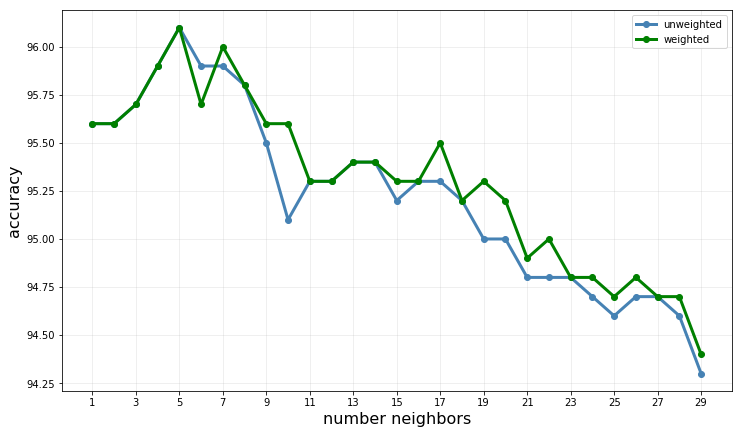

In [25]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,7))
ax.plot(allks, acc, marker="o", color="steelblue", lw=3, label="unweighted")
ax.plot(allks, wacc, marker="o", color="green", lw=3, label="weighted")
ax.set_xlabel("number neighbors", fontsize=16)
ax.set_ylabel("accuracy", fontsize=16)
ax.legend(loc="upper right")
plt.xticks(range(1,31,2))
ax.grid(alpha=0.25)

**[4 points]** Based on the plot, answer the following questions: 

- For general $K$, does Unweighted or Weighted KNN appear to perform better? 
- Which value of $K$ attains the best accuracy on the validation set? 


- **In General, weighted KNN appears to have slightly better accuracy.**
- **$K = 5$ attains the best accuracy in the validation set.**

### [30 points] Problem 3 - Polynomial Regression  and the Bias-Variance Trade-Off
***

In this problem you will use polynomial regression to explore the Bias-Variance Trade-Off. Assume that our data comes from a model of the form 

$$Y = f(X) + \epsilon ~~\textrm{ where }~~ \epsilon \sim N(0,\sigma^2)$$ 

For our experiments we'll use $f(x) = \sin(\pi x)$. The following functions can be used to generate data from this distribution:

In [29]:
def get_f(x):
    """
    Returns sin(pi*x) for array of x values
    
    :@param x: ndarray of feature values
    """
    return np.sin(np.pi * x)

**Part A [6 points]**: **[3 points]** Generate a sample of size $n=20$ for $x$-values chosen from a uniform distribution between $0$ and $1$.

In [30]:
def get_y(x, sigma=1.0):
    """
    Returns y values based on the data generation process.
    Note the noise term.
    
    :@param x: ndarray of feature values
    """
    return get_f(x) + np.random.normal(0,sigma,len(x))
def sample(n, sigma=1.0):
    """Return tuples of data (x, y) that come from 
    the data generation process."""
    x = np.random.uniform(0, 1, size=n)
    y = get_y(x, sigma=sigma)
    return x, y

**[3 points]**: Make a scatter plot of the data overlayed with the curve of the true function $f(x)=\sin(\pi x)$. 

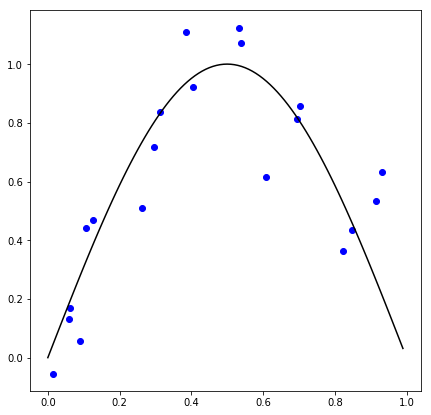

In [31]:
n = 20
x, y = sample(n, sigma=.15)
xplot = np.linspace(0, 1, 200)
fplot = get_f(xplot)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,7))
ax.plot(x,y,"bo")

line_x = np.arange(0,1,0.01)
ax.plot(line_x, get_f(line_x), "k")

**Part B [6 points]**: **[3 points]** Next we need to create a function that can fit a polynomial model to training data and make predictions for unseen data.  Complete the function `poly_predict` below to accomplish this.  Note that there are many ways to do this in Python.  Later this week we'll look into doing this with Scikit-Learn.  You're free to implement it using Scikit-Learn, but you might want to look into Numpy's polynomial fitting functions, [polyfit](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.polyfit.html) and [polyval](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.polyval.html).

In [32]:
def poly_predict(x_train, y_train, x_valid, deg):
    """
    Function to train polynomial regression model on training data
    and then return a vector of predictions on validation data
    
    :@param x_train: vector of training features
    :@param y_train: vector of training responses
    :@param x_valid: vector of validation features to make predictions with
    :@param deg: degree of the polynomial model 
    """
    z_hat = np.poly1d(np.polyfit(x_train,y_train,deg))
    
    prediction = z_hat(x_valid)
    return prediction

**[3 points]**: Demonstrate that your function is working by using it to generate a plot that include the true function $f(x)$, a scatter plot of your training data, and the curve representing your fitted model. 

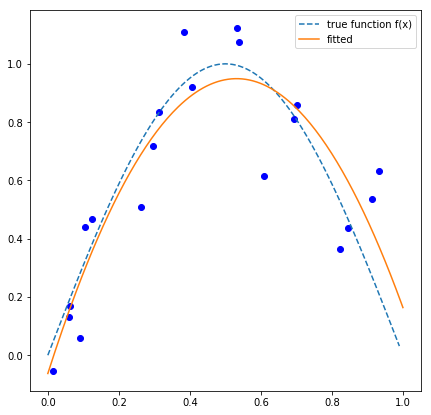

In [33]:
model_plot = poly_predict(x, y, xplot, 2)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,7))
ax.plot(x,y,"bo")
ax.plot(line_x, get_f(line_x), "--", label="true function f(x)")
ax.plot(xplot,model_plot, label="fitted")
ax.legend(loc="upper right")

**Part C [12 points]**: Our goal now will be to make a plot of the decomposition of the expected validation MSE into it's constituent parts.  Recall that we showed in lecture that the expected test MSE can be written as 

$$
\textrm{E}\left[\left(y_0 - \hat{f}(x_0) \right)^2\right] = \left[~f(x_0) - \textrm{E}[~\hat{f}(x_0)~] \right]^2
+ \textrm{E}\left[ ~ \textrm{E}[~\hat{f}(x_0)]-\hat{f}(x_0)~\right]^2 + \textrm{Var}(\epsilon)
= \left[\textrm{Bias}(~\hat{f}(x_0)\right]^2 + \textrm{Var}(~\hat{f}(x_0)~) + \textrm{Var}(\epsilon)
$$

where $x_0$ represents unseen validation data. We're going to run simulations to estimate $\left[\textrm{Bias}(~\hat{f}(x_0)\right]^2$ and $\textrm{Var}(~\hat{f}(x_0)~)$ for different polynomial models and then plot them against estimates of the true validation MSE. The function `bias_variance_study` below will help you do this.  You just need to fill in a few key parts.  At the end of the day, you should have a plot that looks like this for certain choices of the simulation parameters. 

The $\textrm{Bias}^2$ term is given by 

$$
\left[\textrm{Bias}(~\hat{f}(x_0)\right]^2 = \left[~f(x_0) - \textrm{E}[~\hat{f}(x_0)~] \right]^2
$$

The first term inside the square is simply the true function $f$ evaluated on the validation data.  The second term inside the square, $\textrm{E}[~\hat{f}(x_0)~]$, is the expected value of all estimated models evaluated on the validation data.  We can estimate this by sampling many many training sets, fitting models, evaluating them on many validation sets, and then taking the average. Complete the `squared_bias` function below to do this computation.  

The next step is to estimate the $\textrm{Variance}$.  Let's unpack it 

$$
\textrm{E}\left[ ~ \hat{f}(x_0) - \textrm{E}[~\hat{f}(x_0)]~\right]^2
$$

Note that $\textrm{E}[~\hat{f}(x_0)]$ is the `mean_model` we got from the `squared_bias` function. The other term, $\hat{f}(x_0)$, is a model estimated on a random training set, and then evaluated on the validation set.  Since we're wrapping this whole thing in an expectation, we're going to sample many many training sets, estimate $\hat{f}(x_0)$, and then compute the mean squared deviation between these and the `mean_model`.  You will add code to the function below to accomplish this. 

We'll also estimate the validation MSE so we can compare this to the bias-variance decomposition, but this portion of the code is completed for you. 

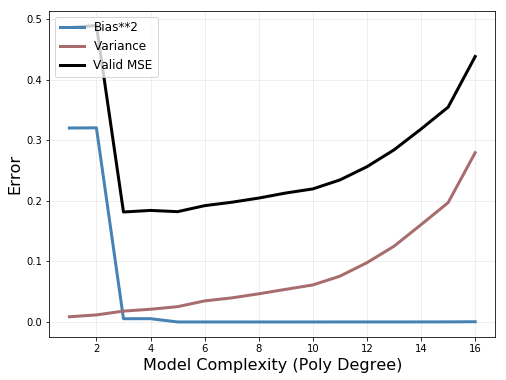

In [34]:
def bias_variance_study(num_data, num_sims, train_frac=0.8, sigma=0.4, max_deg=10, random_state=1234):
    '''
    Function to run simulations and estimate the squared-bias, variance, and 
    validation error of polynomial regression models. 
    
    :@param num_data: number of points in simulated data set 
    :@param num_sims: number of simulations to run 
    :@param train_frac: fraction of total data in training set
    :@param sigma: standard deviation of noise in data 
    :@param max_deg: largest degree polynomial to analyze
    :@param random_state: seed for random state, for reproducibility
    '''
    # Set random seed 
    np.random.seed(random_state)
    
    # array of polynomial degrees
    degrees = range(1, max_deg + 1)
    
    # train/valid split sizes 
    num_train = int(np.ceil(train_frac * num_data)) # 24
    num_valid = num_data - num_train # 6
    
    # Generate grid of features and shuffle them 
    x_grid = np.linspace(-1, 1, num_data)
    np.random.shuffle(x_grid) # 30 shuffled integers from -1, 1
    
    # Spit into training and validation sets 
    x_train = x_grid[:num_train] # 24 of the shuffled integers
    x_valid = x_grid[num_train:] # 6 of the shuffled integers
    
    # Dictionaries for predictions and MSE measurements
    # Keys are polynomial degree. Each prediction is column 
    # of nValid x num_sims array. Each mse is entry in vector
    # of length num_sims 
    y_hat_valid = {deg: np.zeros((num_valid, num_sims)) for deg in degrees}
    mses_valid = {deg: np.zeros(num_sims) for deg in degrees}
    
    # Loop over num_sims simulated data sets
    for sim in range(num_sims):
        
        # Generate training and validation responses 
        y_train = get_y(x_train, sigma=sigma) # sin(pi * x) + noise of random train
        y_valid = get_y(x_valid, sigma=sigma) # sin(pi* x) + noise of random valid
        
        # Loop over polynomial degree.  Use function from part B 
        # to fit to training set and predict on validation set.
        # Store predictions those predictions in yHatValid[deg]
        for d in degrees:
            y_hat_valid[d][:,sim] = poly_predict(x_train, y_train, x_valid, d) # prediction using increasing degrees
            mses_valid[d][sim] = np.mean((y_valid-y_hat_valid[d][:,sim])**2)
    
    # Loop over each polynomial degree and compute squared-bias, variance, 
    # and mean MSE on validation set.  
    bias_squared, variance, mse_valid = np.zeros(max_deg), np.zeros(max_deg), np.zeros(max_deg) 

    for i, d in enumerate(degrees):
        bias_squared[i] = np.mean((get_f(x_valid)-np.mean(y_hat_valid[d],axis=1))**2)
        variance[i] = np.mean(np.var(y_hat_valid[d],axis=1))
        mse_valid[i] = np.mean(mses_valid[d])
        
    # Plot squared bias, variance, and validation MSE 
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
    ax.plot(degrees, bias_squared, color="steelblue", lw=3, label="Bias**2")
    ax.plot(degrees, variance, color="#a76c6e", lw=3, label="Variance")
    ax.plot(degrees, mse_valid, color="black", lw=3, label="Valid MSE")
    ax.grid(alpha=0.25)
    ax.set_xlabel("Model Complexity (Poly Degree)", fontsize=16)
    ax.set_ylabel("Error", fontsize=16)
    ax.legend(loc="upper left", fontsize=12)
    
    # Return arrays of squared-Bias, variance, and MSE 
    return bias_squared, variance, mse_valid
    
        
bias_squared, variance, mse_valid = bias_variance_study(50, 1000, train_frac=0.80,
                                                        sigma=0.4, max_deg=16,
                                                        random_state=1241)

**Part D [6 points]**: When everything is working, increase the size of the simulated data sets and the number of simulation runs and compare the difference between the validation MSE and the sum of the squared-Bias the Variance for each polynomial degree.  Try this for several values of the standard deviation of the model noise.  What do you notice?  How can you explain this result using the notions of Bias-Variance and Reducible and Irreducible error discussed in class?

**For any datasets, a poly degree of 1 has a high bias. Moving above poly degree of 2, the bias drops sharply as the model fits more closely. As the poly degree continus to increase, the variance increases as the model begins to overfit, and the bias remains low. If the dataset size is increased, the variance still climbs as the poly degree increases, but much more slowly, and thus the reducible error is lowered. As the standard deviation increases, the difference between the validation MSE and the sum of the bias^2 and variance increases. These behaviors together show the intuition that an unflexible model will have high bias and low varience, an overly sensitive model will have high varienc and low bias, and the irreducible error increases as the standard deviation increases**